# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка и загрузка данных

Загрузим необходимые библиотеки

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
!pip install optuna -q
!pip install lightgbm -q

Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from lightgbm import early_stopping


import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [3]:
try:
    auto = pd.read_csv('/datasets/autos.csv')
except:
    auto = pd.read_csv('F:\\Учеба яндекс\\projects\\10_NBNC\\autos.csv')

### Подготовка данных

In [4]:
def first_look(df):
    df.info()
    return display(df.describe(),df.head(10))

Выполним первоначальный осмотр данных

In [5]:
first_look(auto)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Заметно, что в данных присутствуют пропуски, требуется изменение формата столбцов с указанием даты и времени, в столбце с числом фотографий авто в объявлении заполнен нулями, что говорит о неккоректной работе кода, загружающего данную информацию в таблицу, в остальном, данные логичны, требуется проведение дальнейшего анализа.

#### Приведение к нужному формату

Переименование столбцов

In [6]:
auto.columns = auto.columns.str.lower()

In [7]:
auto.rename(columns = {'datecrawled':'date_crawled', 'vehicletype':'vehicle_type','registrationyear':'registration_year',\
            'registrationmonth':'registration_month','fueltype':'fuel_type','datecreated':'date_created',\
            'numberofpictures':'number_of_pictures','postalcode':'postal_code','lastseen':'last_seen'}, inplace = True)

Установление формата для столбцов, содержащих информацию о дате

In [8]:
auto['date_crawled'] = pd.to_datetime(auto['date_crawled'], format = '%Y-%m-%d %H:%M:%S')
auto['date_created'] = pd.to_datetime(auto['date_created'], format = '%Y-%m-%d %H:%M:%S')
auto['last_seen'] = pd.to_datetime(auto['last_seen'], format = '%Y-%m-%d %H:%M:%S')

Приведение к нижнему регистру значений в столбцах со строковыми данными

In [9]:
columns_list = ['vehicle_type','gearbox','model','fuel_type','brand','repaired']

for _column in columns_list:
    auto[_column] = auto[_column].str.lower()

#### Удаление нерепрезентативных данных

Данные о времени и дате скачивания анкеты из базы, почтовый индекс владельца анкеты не дадут никакой нужной информации, которая могла бы помочь решить поставленную задачу. Данные о количестве фотографий авто в анкете отсутствуют. Исключим эти столбцы из дальнейшего анализа.

Так же имеет смысл заменить столбец с информацией о последней активности на столбец, содержащий информацию о времени активности с момента создания анкеты, так как из предварительного анализа видно, что эти даты располагаются недалеко друг от друга.

In [10]:
auto['activ_time'] = auto['last_seen'] - auto['date_created']

Необходимо сообщить в службу поддержки о неработоспособности действующего механизма выгрузки информации о количестве фото в объявлении.

#### Пропущенные значения

Посмотрим количество пропущенных значений в столбцах

In [11]:
auto.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
activ_time                0
dtype: int64

**Тип кузова автомобиля**

Пропуски не могут быть восстановлены ввиду того, что у пары бренд, модель может быть не один тип кузова в ассортименте.

Заполним пропуски в данных строкой other

In [12]:
auto['vehicle_type'].fillna('other', inplace = True)

**Коробка передач**

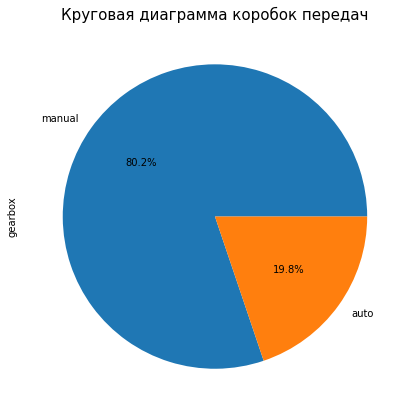

In [13]:
auto['gearbox'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%', figsize = (9, 7))
plt.title('Круговая диаграмма коробок передач', size = 15)
plt.show()

Наиболее вероятной можно считать установку в автомобиль ручной коробки передач
Заполним пропуски строкой manual

In [14]:
auto['gearbox'].fillna('manual', inplace = True)

**Марка авто**

Пропуски не могут быть восстановлены по той же причине, что и у типа кузова.

In [15]:
auto['model'].fillna('other', inplace = True)

**Тип топлива**

In [16]:
auto['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

Заменим американское обозначение бензина на английское

In [17]:
auto['fuel_type'].replace({'gasoline':'petrol'}, inplace = True)

Наиболее вероятной можно считать установку в автомобиль двигателя внутреннего сгорания на жидком топливе
Заполним пропуски строкой petrol

In [18]:
auto['fuel_type'].fillna('petrol', inplace = True)

**Наличие ремонтов**

Вероятнее всего пропущенное значение означает отсутствие информации о наличии таковых. В дополнение, заменим строковые значения на 1 и 0, наличие и отсутсвие ремонтов соответственно.

In [19]:
auto['repaired'] = pd.to_numeric(auto['repaired'].map({'yes':1,'no':0}).fillna(0))

#### Дубликаты

In [20]:
auto.duplicated().sum()

5

In [21]:
auto[auto.duplicated(keep = False)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,activ_time
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,petrol,volkswagen,0.0,2016-03-18,0,36391,2016-03-18 18:46:15,0 days 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,0.0,2016-03-08,0,89518,2016-03-09 09:46:57,1 days 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,0.0,2016-03-28,0,66589,2016-03-28 08:46:21,0 days 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,0.0,2016-03-08,0,89518,2016-03-09 09:46:57,1 days 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,1.0,2016-04-03,0,75196,2016-04-07 09:44:54,4 days 09:44:54
189060,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,petrol,audi,0.0,2016-04-04,0,65428,2016-04-05 12:30:14,1 days 12:30:14
194008,2016-04-04 22:50:44,13000,sedan,2008,manual,143,a4,125000,9,petrol,audi,0.0,2016-04-04,0,65428,2016-04-05 12:30:14,1 days 12:30:14
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,0.0,2016-03-28,0,66589,2016-03-28 08:46:21,0 days 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,1.0,2016-04-03,0,75196,2016-04-07 09:44:54,4 days 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,petrol,volkswagen,0.0,2016-03-18,0,36391,2016-03-18 18:46:15,0 days 18:46:15


Какая-либо закономерность в дубликатах не прослеживается.

Дубликаты следует исключить из анализа.

In [22]:
auto.drop_duplicates(inplace = True)

#### Обработка аномальных значений

In [23]:
auto.describe()

,price,registration_year,power,kilometer,registration_month,repaired,number_of_pictures,postal_code,activ_time
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000,354364
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.101740,0.0,50508.461698,9 days 04:39:02.053890914
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.302307,0.0,25783.124276,8 days 14:31:03.829745740
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,0.0,1067.000000,0 days 00:25:36
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,0.0,30165.000000,2 days 12:45:57
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,0.0,49409.500000,6 days 10:45:54
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.000000,0.0,71083.000000,13 days 22:18:00.250000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000,0.0,99998.000000,759 days 04:46:24


In [24]:
auto_selected = auto.copy()

In [25]:
auto_selected = auto_selected.drop(['number_of_pictures','postal_code', 'date_crawled','last_seen'], axis = 1)

Из анализа данных видно, что вибивающиеся или неправдоподобные значения имеют несколько столбцов:
* цена авто не может быть равна 0;
* год регистрации не может быть меньше ~1800 и больше 2025;
* мощность не может быть равна 0, авто с мощностью более 1500 л.с. - редкость, 20000 л.с. - аномалия;

In [26]:
def num_feature(data):
    display(data.describe())
    data.plot(kind = 'box', grid = True, figsize = (9,7))
    plt.title(f'Диаграмма размаха {data.name}', size = 15)
    plt.xlabel(data.name, size = 12)
    plt.show()
    data.hist(bins = 15, figsize = (9,7), edgecolor='black')
    plt.title(f'Гистограмма {data.name}', size = 15)
    plt.ylabel('Количество записей', size = 12)
    plt.xlabel(data.name, size = 12)
    plt.show()

##### Цена

count    354364.000000
mean       4416.655608
std        4514.159690
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

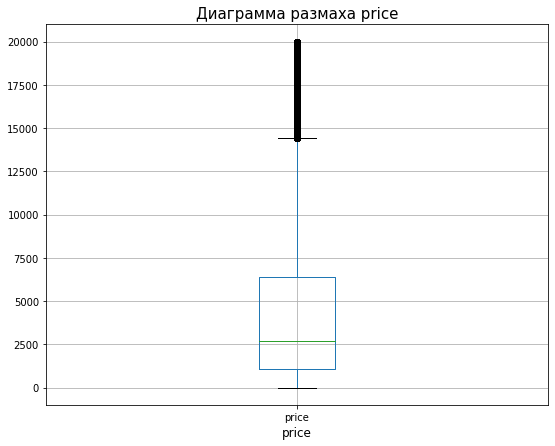

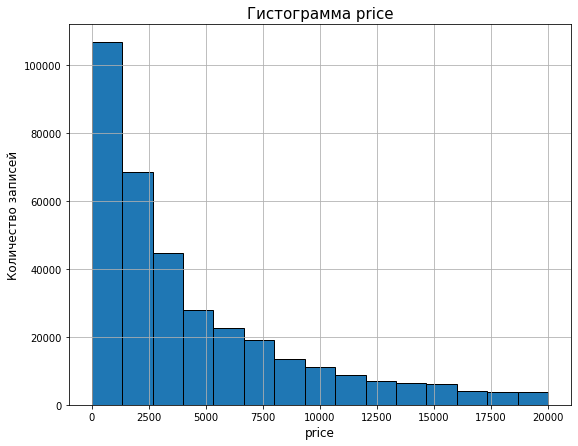

In [27]:
num_feature(auto_selected['price'])

In [28]:
auto_selected.query('price < 500').describe()

,price,registration_year,power,kilometer,registration_month,repaired,activ_time
count,36054.000000,36054.000000,36054.000000,36054.000000,36054.000000,36054.000000,36054
mean,192.706357,2004.850807,67.248544,129890.996838,3.991707,0.268042,7 days 18:54:13.079325456
std,168.061252,205.624369,190.428930,43440.462675,3.987932,0.442946,7 days 22:49:27.180845691
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,0 days 00:36:16
25%,0.000000,1996.000000,0.000000,150000.000000,0.000000,0.000000,1 days 14:47:12.750000
50%,200.000000,1998.000000,60.000000,150000.000000,3.000000,0.000000,4 days 16:45:52.500000
75%,350.000000,2001.000000,95.000000,150000.000000,7.000000,1.000000,11 days 09:44:42.250000
max,499.000000,9999.000000,15016.000000,150000.000000,12.000000,1.000000,76 days 18:45:27


Закономерности в данных по авто с ценой ниже 500 евро не наблюдается, поэтому нельзя однозначно сказать, является ли такая низкая цена ошибкой или действительно продавец расчитывает получить именно указанную сумму. Ограничимся порогом в 200 евро за самый дешевый авто.

In [29]:
auto_selected = auto_selected.query('price >= 200')

##### Год регистрации авто

count    336902.000000
mean       2003.979967
std          67.939104
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

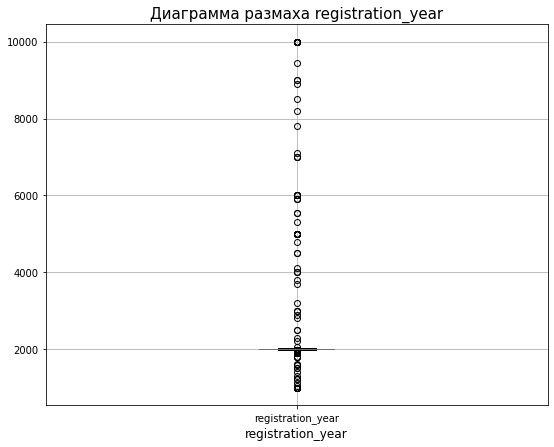

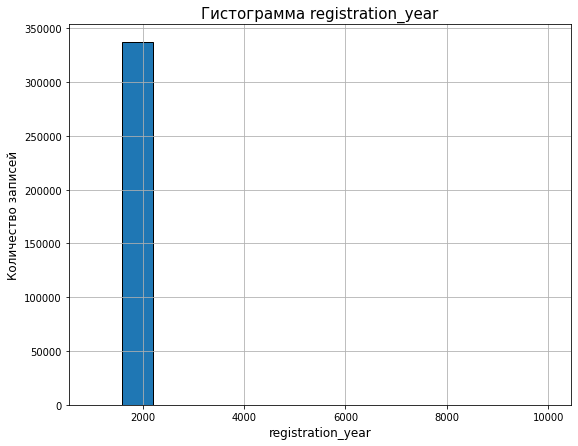

In [30]:
num_feature(auto_selected['registration_year'])

Проверим выбивающиеся данные

In [31]:
auto_selected.query('registration_year < 1972 or registration_year > 2025')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,activ_time
15,450,small,1910,manual,0,ka,5000,0,petrol,ford,0.0,2016-03-11,8 days 08:46:47
630,12000,sedan,1969,manual,140,s_klasse,80000,3,petrol,mercedes_benz,0.0,2016-03-18,18 days 22:16:44
650,15000,coupe,1971,manual,0,other,5000,4,petrol,sonstige_autos,0.0,2016-03-30,8 days 02:45:10
981,2900,sedan,1971,auto,90,other,90000,6,petrol,opel,0.0,2016-03-05,31 days 11:48:37
1235,4450,small,1971,manual,23,500,70000,5,petrol,fiat,0.0,2016-03-08,28 days 18:44:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353531,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,0.0,2016-03-16,14 days 18:47:41
353912,800,other,1970,manual,0,other,150000,0,petrol,trabant,0.0,2016-03-05,7 days 08:17:10
353961,200,other,1910,manual,0,other,5000,0,petrol,sonstige_autos,0.0,2016-03-17,14 days 22:46:47
354037,10500,convertible,1968,manual,54,other,20000,4,petrol,renault,0.0,2016-03-23,2 days 00:47:18


Зависимости в данных не наблюдается.

Ограничимся 99% данных

In [32]:
upper_b = np.percentile(auto_selected['registration_year'],99.5)
upper_b

2018.0

In [33]:
lower_b = np.percentile(auto_selected['registration_year'],0.5)
lower_b

1972.0

In [34]:
auto_selected = auto_selected.query('registration_year > @lower_b and registration_year < @upper_b')

In [35]:
auto.query('registration_year < 1950 or registration_year > 2025')[['date_crawled',\
                                                                    'price',\
                                                                    'registration_year',\
                                                                    'kilometer',\
                                                                    'date_created']].head(50)

,date_crawled,price,registration_year,kilometer,date_created
15,2016-03-11 21:39:15,450,1910,5000,2016-03-11
622,2016-03-16 16:55:09,0,1111,5000,2016-03-16
1928,2016-03-25 15:58:21,7000,1945,150000,2016-03-25
2273,2016-03-15 21:44:32,1800,1925,5000,2016-03-15
6629,2016-04-02 13:47:16,0,1910,5000,2016-04-02
6977,2016-03-24 08:37:22,135,1910,5000,2016-03-24
10183,2016-03-27 13:59:08,1250,1910,5000,2016-03-27
12946,2016-03-29 18:39:40,49,5000,5000,2016-03-29
15147,2016-03-14 00:52:02,0,9999,10000,2016-03-13
15870,2016-04-02 11:55:48,1700,3200,5000,2016-04-02


count    331349.000000
mean       2003.293379
std           6.573388
min        1973.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2017.000000
Name: registration_year, dtype: float64

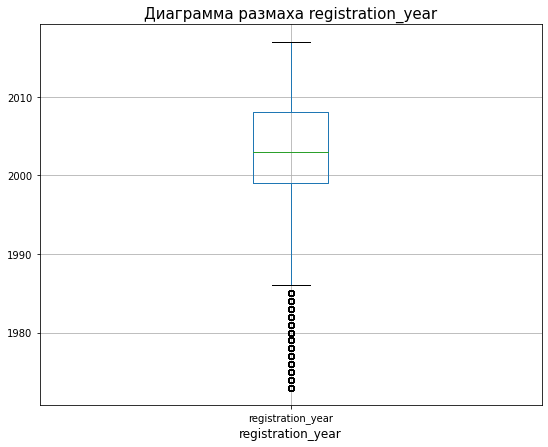

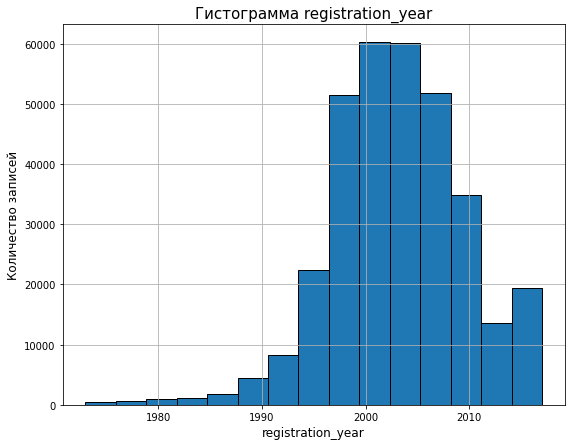

In [36]:
num_feature(auto_selected['registration_year'])

##### Мощность

count    331349.000000
mean        112.557780
std         184.448322
min           0.000000
25%          73.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

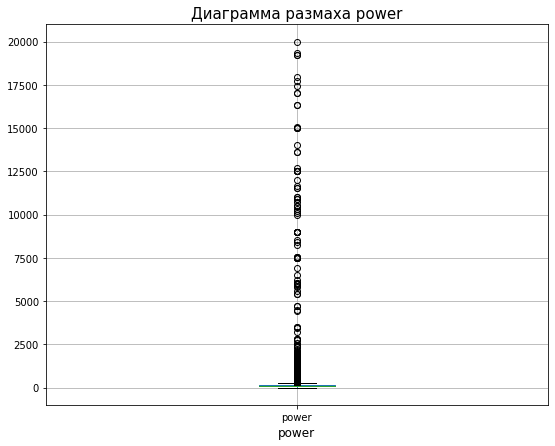

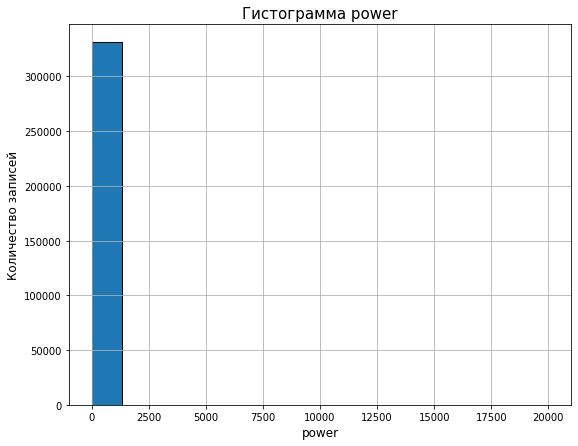

In [37]:
num_feature(auto_selected['power'])

In [38]:
auto_selected.query('power > 1000')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,activ_time
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,0.0,2016-03-22,0 days 21:43:26
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,0.0,2016-03-29,8 days 05:44:36
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,0.0,2016-04-02,4 days 11:46:49
7720,1500,small,2000,manual,1400,other,150000,0,petrol,honda,0.0,2016-04-02,2 days 09:15:26
9664,2599,other,2016,manual,1779,zafira,150000,0,petrol,opel,0.0,2016-03-14,24 days 09:45:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,0.0,2016-03-13,24 days 15:17:39
348968,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,1.0,2016-04-04,0 days 18:53:25
351947,1500,bus,2001,manual,1001,zafira,5000,7,petrol,opel,0.0,2016-03-07,2 days 12:47:08
353493,12500,other,2017,manual,2000,other,60000,0,petrol,chrysler,0.0,2016-04-02,4 days 21:44:39


In [39]:
auto_selected.query('power < 10')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,activ_time
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,0.0,2016-03-24,14 days 03:16:57
32,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,0.0,2016-03-15,2 days 18:17:43
37,1500,other,2016,manual,0,kangoo,150000,1,petrol,renault,0.0,2016-03-28,2 days 09:18:02
54,4700,wagon,2005,manual,0,signum,150000,0,petrol,opel,0.0,2016-03-17,18 days 04:17:32
55,550,wagon,1999,manual,0,astra,150000,8,petrol,opel,1.0,2016-03-26,6 days 23:17:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,3299,other,2005,auto,0,outlander,150000,4,petrol,mitsubishi,0.0,2016-03-05,1 days 04:17:37
354346,2600,other,2005,auto,0,c_klasse,150000,9,petrol,mercedes_benz,0.0,2016-03-07,1 days 21:28:38
354360,3999,wagon,2005,manual,3,3er,150000,5,petrol,bmw,0.0,2016-04-02,4 days 20:47:12
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,0.0,2016-03-27,2 days 10:17:23


Анализ показал, что есть немалое количество данных с авто мощностью 0 л.с., что невозможно. Наиболее вероятно, люди, заполняющие данные по автомобилю указывали 0 в том случае, если не знали точное количество лошадиных сил в своем авто.

Для того, чтобы избежать потери около 10% данных датасета, можно сделать категоризацию данного признака, а именно выделить 5 категорий авто:
* без двигателя - 0 л.с.,
* маломощные - до 100 л.с.,
* срдней мощности - 100 - 200 л.с.,
* мощные - 200 - 300 л.с.,
* особой мощности - более 300 л.с.

Людей, которые не заполнили информацию о мощности авто, вероятнее мало волнует количество лошадиных сил. Поэтому, можно предположить, что их авто вероятнее всего попадут в категорию маломощных.

Авто с мощностью более 1000 л.с. можно исключить из анализа, так как такие данные могут  лишь зашумить общую картину.

In [40]:
auto_selected = auto_selected.query('power < 1000')

In [41]:
def power_cat(value):
    if value == 0:
        return 0
    if value < 100:
        return 1
    if value < 200:
        return 2
    if value < 300:
        return 3
    else:
        return 4

In [42]:
auto_selected['power_cat'] = auto_selected['power'].map(power_cat)

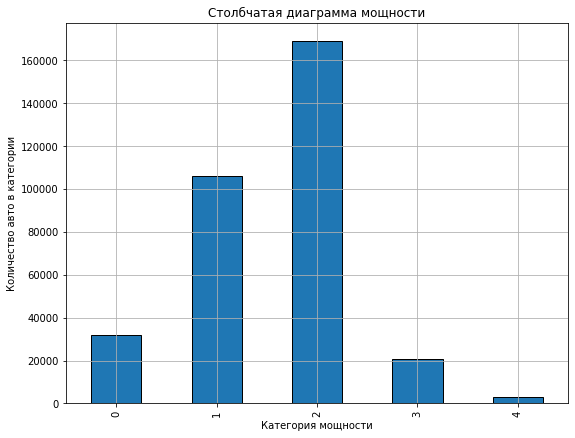

In [43]:
auto_selected.groupby('power_cat')['price'].count().plot(kind = 'bar',
                                                         figsize = (9,7),
                                                        edgecolor='black',
                                                        grid = True)
plt.title('Столбчатая диаграмма мощности', size = 12)
plt.xlabel('Категория мощности')
plt.ylabel('Количество авто в категории')
plt.show()

In [44]:
auto_selected = auto_selected.drop('power', axis = 1)

In [45]:
auto_selected.describe()

,price,registration_year,kilometer,registration_month,repaired,activ_time,power_cat
count,331079.000000,331079.000000,331079.000000,331079.000000,331079.000000,331079,331079.000000
mean,4638.408785,2003.293851,128729.985895,5.842636,0.095666,9 days 06:13:58.035662183,1.566617
std,4510.900919,6.573337,36869.914350,3.673778,0.294133,8 days 15:15:07.530165164,0.788367
min,200.000000,1973.000000,5000.000000,0.000000,0.000000,0 days 00:36:14,0.000000
25%,1250.000000,1999.000000,125000.000000,3.000000,0.000000,2 days 13:17:30,1.000000
50%,2950.000000,2003.000000,150000.000000,6.000000,0.000000,6 days 11:45:59,2.000000
75%,6600.000000,2008.000000,150000.000000,9.000000,0.000000,14 days 00:15:55,2.000000
max,20000.000000,2017.000000,150000.000000,12.000000,1.000000,759 days 04:46:24,4.000000


**Вывод**: выполнена загрузка данных, подготовка, в ходе которой:
 
1) приведены к змеиному языку названий столбцов;

2) приведены столбцы, содержащие информацию о дате и времени, к формату datetime;

3) обнаружены и исключены из анализа столбцы, непредоставляющий полезной информации;

4) обработаны пропуски в данных;

5) исключены строки-дубликаты из анализа;

6) обработаны аномальные значения в столбцах цена, год регистрации и мощность.

## Обучение моделей

Зафиксируем необходимые константы

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Переведем datetime в float для возможности скалирования

In [ ]:
auto_selected['date_created'] = auto_selected['date_created'].map(pd.Timestamp.timestamp)

In [ ]:
auto_selected['activ_time'] = auto_selected['activ_time']/pd.Timedelta(1, unit = 'day')

Разобъем данные на тестовую и тренировочную выборки

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(
    auto_selected.drop('price', axis = 1),
    auto_selected['price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(
    X_train,
    y_train,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

Отделим категорийные признаки от числовых

In [ ]:
num_cols = X_train.select_dtypes('number').columns.tolist()
num_cols

In [ ]:
ohe_cols = X_train.columns.drop(num_cols).tolist()

ohe_cols

In [ ]:
preprocessor = ColumnTransformer(
[
    ('ohe', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'), ohe_cols),
    ('num', StandardScaler(),num_cols)
], remainder = 'passthrough')

### Дерево регрессии

In [ ]:
def tree_objective(trial):
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    reg = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', DecisionTreeRegressor(max_depth=max_depth,
                                               min_samples_split=min_samples_split,
                                               min_samples_leaf=min_samples_leaf,
                                               random_state=RANDOM_STATE))
        ])
    
    
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred, squared=False)
    
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')  
study.optimize(tree_objective, n_trials=30)

In [ ]:
best_params = study.best_params
best_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                       min_samples_split=best_params['min_samples_split'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       random_state=42))
])

In [ ]:
%%time
best_reg.fit(X_train, y_train)

In [ ]:
tree_time_studing = 6.7

In [ ]:
%%time
y_pred_train = best_reg.predict(X_train)

In [ ]:
tree_time_predict = 0.7

In [ ]:
f'Оптимальные гиперпараметры {study.best_params}'

In [ ]:
tree_mse_val = study.best_value
f'Достигнутая подбором гиперпараметров величина RMSE для дерева регрессии {tree_mse_val:.2f}'

**Результат:** подбор гиперпараметров для дерева регрессии позволил найти оптимальные параметры: 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 5; RMSE модели с оптимальными параметрами для валидационной выборки - 1931.45 евро, время обучения равно 6.7 с, предсказания - 0.7 с.

### LGBM

In [ ]:
X_train[ohe_cols] = X_train[ohe_cols].astype('category')
X_val[ohe_cols] = X_val[ohe_cols].astype('category')
X_test[ohe_cols] = X_test[ohe_cols].astype('category')

In [ ]:
def lgbm_objective(trial):
    params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'n_estimators': 10000,
        
        # параметры, которые будем отбирать
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0)

    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=100)],
        categorical_feature=ohe_cols,
        
    )
    
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred, squared=False)
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')  
study.optimize(lgbm_objective, n_trials=10, n_jobs = -1)

In [ ]:
best_params = study.best_params
lgbm_reg = lgb.LGBMRegressor(objective = 'regression',
                         verbosity = -1,
                         boosting_type = 'gbdt',
                         random_state = RANDOM_STATE,
                         n_estimators = 10000,
                        
                        learning_rate = best_params['learning_rate'],
                        num_leaves = best_params['num_leaves'],
                        max_depth = best_params['max_depth'],
                        min_child_samples = best_params['min_child_samples'],
                        subsample = best_params['subsample'],
                        colsample_bytree = best_params['colsample_bytree'])

In [ ]:
%%time
lgbm_reg.fit(X_train, 
                   y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[early_stopping(stopping_rounds=100)],
                   categorical_feature=ohe_cols)

In [ ]:
lgbm_time_studing = 79

In [ ]:
%%time
y_pred_train = lgbm_reg.predict(X_train)

In [ ]:
lgbm_time_predict = 9.7

In [ ]:
f'Оптимальные гиперпараметры {study.best_params}'

In [ ]:
lgbm_mse_val = study.best_value
f'Достигнутая подбором гиперпараметров величина RMSE для градиентного бустинга {lgbm_mse_val:.2f}'

**Результат:** подбор гиперпараметров для градиентного бустинга позволил найти оптимальные параметры: 'learning_rate': 0.153, 'num_leaves': 1459, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.986, 'colsample_bytree': 0.626; RMSE модели с оптимальными параметрами для валидационной выборки - 1584.39 евро, время обучения равно 79 с, предсказания - 9.7 с

**Вывод:** провели обучениемодели дерева регрессии и модели градиентного бустинга, которые показали результаты, удовлетворяющие условию RMSE < 2500: 1931.45 на валидационной выборке для дерева регрессии и 1584.39 - для градиентного бустинга, при этом время обучения и предсказания отличеются на порядок: 6.7 с и 0.7 с - для дерева регрессии; 79 с и 9.7 с - для градиентного бустинга соответственно.

## Анализ моделей

In [ ]:
results = pd.DataFrame(data = {'tree': [round(tree_mse_val,2),
                              tree_time_studing,
                              tree_time_predict],
                             'lgbm':[round(lgbm_mse_val,2),
                              lgbm_time_studing,
                              lgbm_time_predict]},
                      index = ['rmse_val','time_studing','time_predict'])
results['%diff'] = round(abs((results['lgbm'] - results['tree'])/results['lgbm'] * 100),2)
results

Анализ моделей показал, что градиентный бустинг точнее предсказывает целевой показатель как минимум на 20%, однако в то же время, длительность процесса обучения и предсказания на порядок больше, нежели у модели дерева регрессии.
Так как обе модели удовлетворяют поставленному условию в RMSE < 2500, к внедрению рекомендуется наиболее быстрая модель: дерево регрессии.

Предскажем целевой признак выбранной моделью, расчитаем RMSE модели на тестовых данных

In [ ]:
rmse_test = mean_squared_error(y_test,best_reg.predict(X_test), squared = False)

In [ ]:
f'RMSE выбранной модели на тестовой выборке равна {rmse_test:.2f}'

**Оценим важность признаков**

In [ ]:
f_imp = pd.Series(index = best_reg.named_steps['preprocessor'].get_feature_names_out(),
                  data = abs(best_reg.named_steps['regressor'].feature_importances_))


f_imp.sort_values(ascending = False).head(10).plot.bar(figsize = (15,12))
plt.title('Анализ важности признаков', size = 15)
plt.xlabel('Признаки', size = 12)
plt.xticks(rotation=30)
plt.ylabel('Коэффициент', size = 12)
plt.show()

Анализ показывает, что наибольший вес в определении цены за автомобиль игрют признаки, являющиеся общими для всех авто - те, которые задают тренд. Так, в среднем, авто с минимальным возрастом, пробегом и максимальной мощностью будет оценено выше, нежели аналогичное с бОльшим возрастом, пробегом и меньшей мощностью. Также сильное влияние признака категорийной мощности может быть объяснено введением категории 0 - авто без двигателя. Так как он является одной из самых дорогих запчастей, его отсутствие может сильно повлиять на стоимость авто.

**Вывод:** провели обучениемодели дерева регрессии и модели градиентного бустинга, которые показали результаты, удовлетворяющие условию RMSE < 2500: 1931.45 на валидационной выборке для дерева регрессии и 1584.39 - для градиентного бустинга, при этом время обучения и предсказания отличеются на порядок: 6.7 с и 0.7 с - для дерева регрессии; 27.8 с и 9.7 с - для градиентного бустинга соответственно.

## Вывод

Был проведен исследовательский анализ данных сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

**В первой части работы** была выполнена загрузка и предобработка данных при которой были выявлены и устранены пропуски, преобразованы типы данных в некоторых столбцах, найдены и устранены явные дубликаты, проанализированны выбивающиеся значения. В результате предобработки было отсеяно менее 10% данных.

Дополнительно исключены из анализа столбцы, непредоставляющие полезной информации: дефектный столбец с количеством фотографий в объявлении, почтовый код владельца, дата выгрузки информации, добавлены новые столбцы: категория мощности авто, разность между созданием объявления и последней активностью в нем - облегчающие дальнейший анализ данных.

**Во второй части работы** было проведено обучение моделей, предсказывающих целевой признак - цену авто. 

*Для дерева регрессии* были найдены оптимальные гиперпараметры: 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 5, - предсказан целевой признак для валидационной выборки, а также вычислен RMSE модели = 1931.45 евро, время обучения составило 6.7 с, предсказания - 0.7 с.

*Для модели градиентного бустинга* аналогично найдены оптимальные гиперпараметры:   'learning_rate': 0.153, 'num_leaves': 1459, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.986, 'colsample_bytree': 0.626, - предсказан целевой признак для валидационной выборки, а также вычислен RMSE модели = 1584.39 евро, время обучения составило 27.8 с, предсказания - 9.7 с.

Обе модели удовлетворяют условию, поставленному бизнесом: RMSE < 2500.

**Анализ моделей** показал, что градиентный бустинг точнее предсказывает целевой показатель на валидационной выборке как минимум на 20%, однако в то же время, длительность процесса обучения и предсказания на порядок больше, нежели у модели дерева регрессии. Так как бизнесом не даны установки по стоимости одного евро в RMSE к 1 с на обучение и предсказание, и обе модели удовлетворяют поставленному условию, рекомендуется для внедрения модель дерева решения, как имеющая большую скорость выполнения операций.

Для выбранной модели предсказан целевой признак и вычислена величина RMSE на тестовых данных: 1935.10 евро.

Выполлнен анализ важности признаков: наиболее существенными являются год регистрации авто, категория мощности и пробег.